In [1]:
# cargar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
# cargar archivo con datos en una tabla de Pandas (valores separados por comas)
#data = pd.read_csv('https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv')
data = pd.read_csv('dolar_m')
print(data.head())  # muestra los primeros renglones
print('\n Data Types:')
print(data.dtypes)

         Date   Value
0  1993-11-30  3.1498
1  1993-12-31  3.1083
2  1994-01-31  3.1078
3  1994-02-28  3.1218
4  1994-03-31  3.3026

 Data Types:
Date      object
Value    float64
dtype: object


In [5]:
# cargar datos, interpretando la columna "Month" como fechas y usándolas como índice
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#data = pd.read_csv('https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv',
#                   parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data = pd.read_csv('dolar_m',
                   parse_dates=['Date'], index_col='Date',date_parser=dateparse)
print(data.head())

             Value
Date              
1993-11-30  3.1498
1993-12-31  3.1083
1994-01-31  3.1078
1994-02-28  3.1218
1994-03-31  3.3026


In [6]:
# convierte a Series (tipo de datos de Pandas para manejar series)
ts = data['Value']
ts.head(10)

Date
1993-11-30    3.1498
1993-12-31    3.1083
1994-01-31    3.1078
1994-02-28    3.1218
1994-03-31    3.3026
1994-04-30    3.3495
1994-05-31    3.3167
1994-06-30    3.3671
1994-07-31    3.4031
1994-08-31    3.3814
Name: Value, dtype: float64

In [7]:
# datos del año 1949 (se pueden omitir las últimas componentes de una fecha)
ts['2017']

Date
2017-01-31    21.3911
2017-02-28    20.3008
2017-03-31    19.2800
2017-04-30    18.7672
2017-05-31    18.7666
2017-06-30    18.1293
2017-07-31    17.8081
2017-08-31    17.7969
2017-09-30    17.8305
2017-10-31    18.8215
2017-11-30    19.0986
Name: Value, dtype: float64

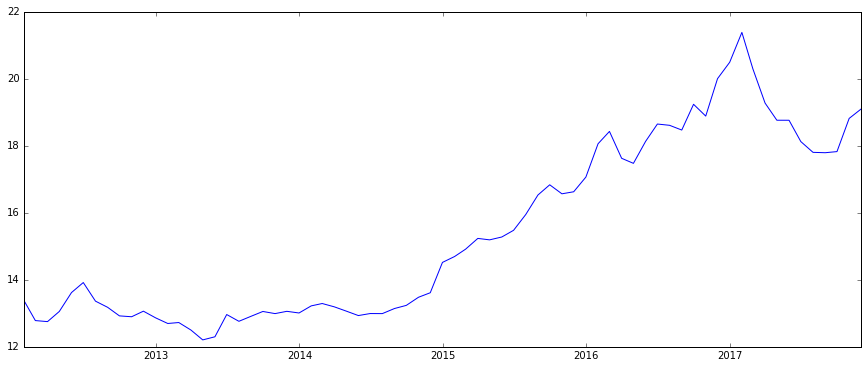

In [10]:
# graficando
plt.plot(ts['2012':])
# se puede observar:
#  tendencia creciente
#  estacionalidad

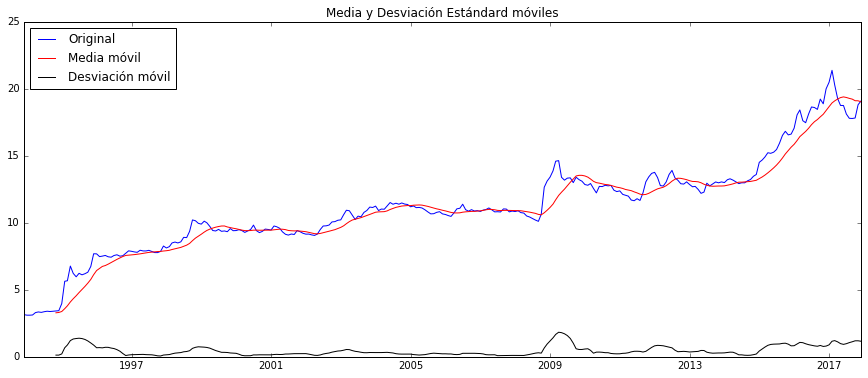

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba     -0.965538
valor-p                       0.765625
#retrasos usados              6.000000
Número de observaciones     282.000000
Valor crítico (1%)           -3.453754
Valor crítico (5%)           -2.871844
Valor crítico (10%)          -2.572261
dtype: float64


In [11]:
# ver si es estacionaria, pues muchos modelos requieren que lo sea
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # mMedidas móviles
    rol = timeseries.rolling(window=12, center=False)
    rolmean = rol.mean()
    rolstd = rol.std()

    #graficar medidas móviles:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviación móvil')
    plt.legend(loc='best')
    plt.title('Media y Desviación Estándard móviles')
    plt.show(block=False)
    
    #Realiza prueba de Dickey-Fuller:
    print ('Resultados de la prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadística de la prueba','valor-p','#retrasos usados','Número de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

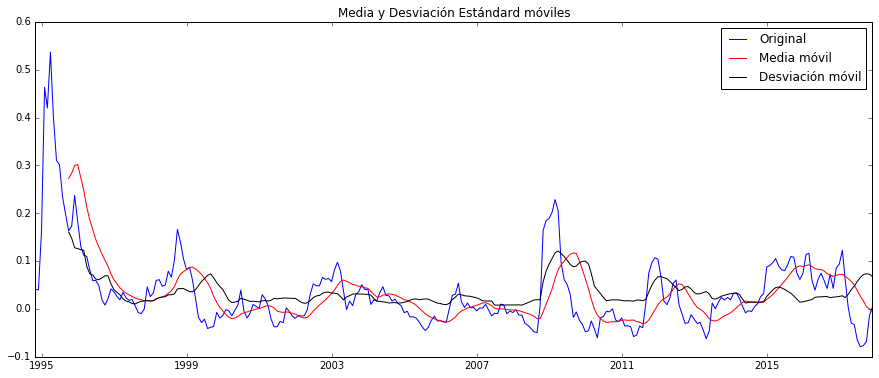

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba     -5.502666
valor-p                       0.000002
#retrasos usados              4.000000
Número de observaciones     273.000000
Valor crítico (1%)           -3.454533
Valor crítico (5%)           -2.872186
Valor crítico (10%)          -2.572443
dtype: float64


In [12]:
# volviéndola estacionaria  (eliminando la tendencia)
ts_log = np.log(ts)  # transformación, le baja un poco la desv. estándar, penalizando valores altos
rol = ts_log.rolling(window=12, center=False)
rolmean = rol.mean()
diferencia = ts_log - rolmean
diferencia.dropna(inplace=True)  # borra elementos nulos
test_stationarity(diferencia) # la serie diferencia es estacionaria del 99%

Date
1993-11-30         NaN
1993-12-31   -0.013263
1994-01-31   -0.000161
1994-02-28    0.004495
1994-03-31    0.056300
Name: Value, dtype: float64


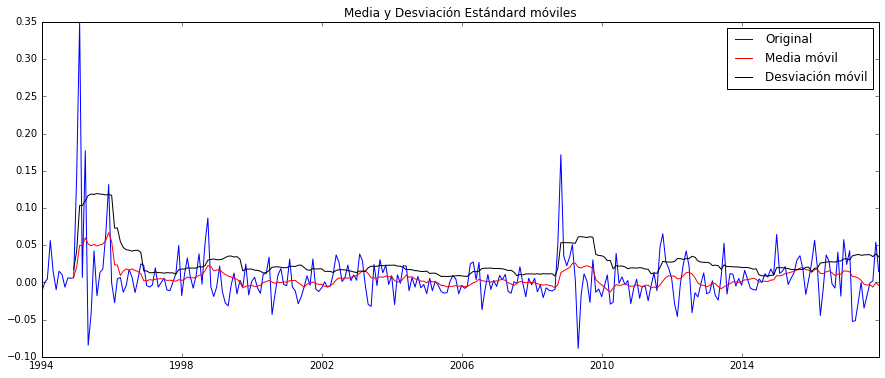

Resultados de la prueba de Dickey-Fuller:
Estadística de la prueba     -5.422252
valor-p                       0.000003
#retrasos usados              7.000000
Número de observaciones     280.000000
Valor crítico (1%)           -3.453922
Valor crítico (5%)           -2.871918
Valor crítico (10%)          -2.572300
dtype: float64


In [13]:
# Eliminando estacionalidad con diferencia (traslape con si misma desplazada en el tiempo)
dif = ts_log - ts_log.shift() # desplazada un lugar
print(dif.head())
dif.dropna(inplace=True)
test_stationarity(dif)  # confianza de 99%

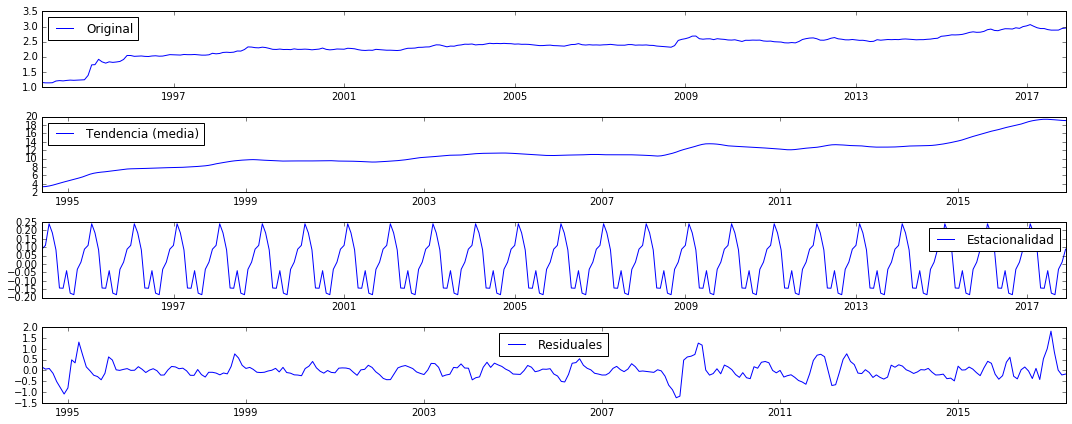

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia (media)')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuales')
plt.legend(loc='best')
plt.tight_layout()

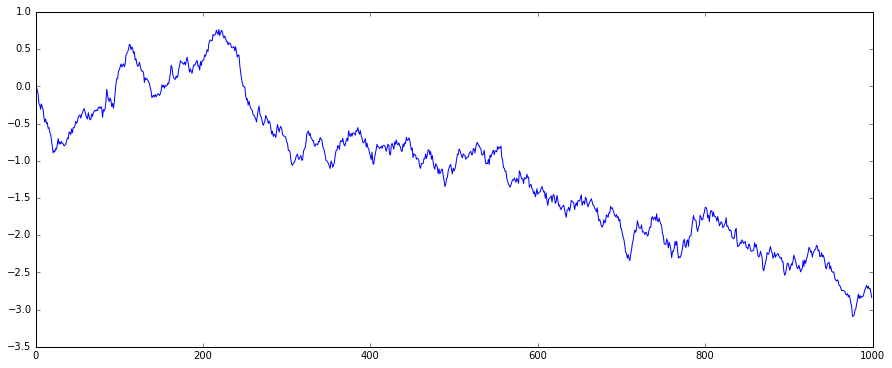

In [30]:
ca = np.random.randn(1000)
plt.plot(ca.cumsum()/18)

In [33]:
nueva = trend+seasonal+residual
nueva.dropna(inplace=True)
nueva

Date
1994-05-31     3.3167
1994-06-30     3.3671
1994-07-31     3.4031
1994-08-31     3.3814
1994-09-30     3.4022
1994-10-31     3.4212
1994-11-30     3.4425
1994-12-31     3.9748
1995-01-31     5.6405
1995-02-28     5.6779
1995-03-31     6.7770
1995-04-30     6.2285
1995-05-31     5.9741
1995-06-30     6.2330
1995-07-31     6.1220
1995-08-31     6.2047
1995-09-30     6.3167
1995-10-31     6.7452
1995-11-30     7.6936
1995-12-31     7.6870
1996-01-31     7.4806
1996-02-29     7.5183
1996-03-31     7.5682
1996-04-30     7.4694
1996-05-31     7.4368
1996-06-30     7.5648
1996-07-31     7.6179
1996-08-31     7.5143
1996-09-30     7.5441
1996-10-31     7.7345
               ...   
2014-12-31    14.5205
2015-01-31    14.6972
2015-02-28    14.9170
2015-03-31    15.2375
2015-04-30    15.1943
2015-05-31    15.2796
2015-06-30    15.4792
2015-07-31    15.9515
2015-08-31    16.5340
2015-09-30    16.8387
2015-10-31    16.5697
2015-11-30    16.6306
2015-12-31    17.0696
2016-01-31    18.0648
2016-

In [34]:
ts["2017-05-31"]

18.7666

In [35]:
ts2=ts[:"2016-12-31"]


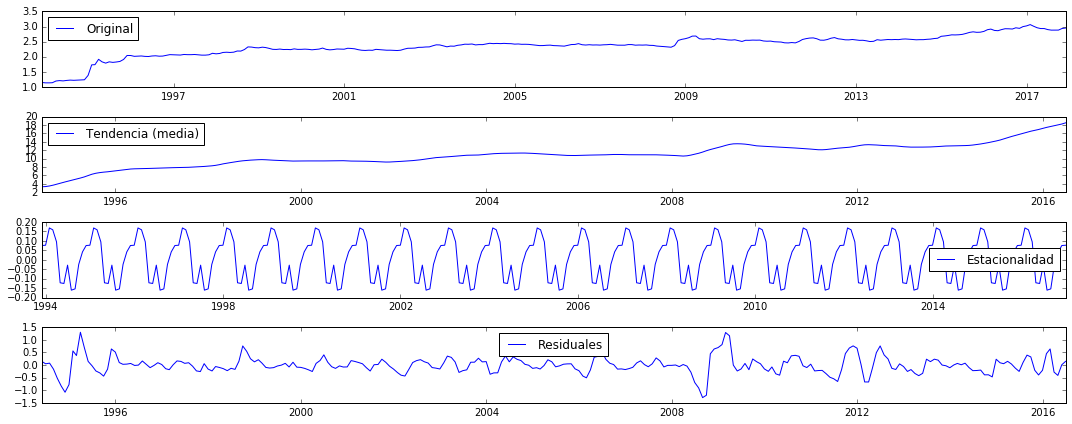

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia (media)')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuales')
plt.legend(loc='best')
plt.tight_layout()

In [65]:
ss= seasonal["1994-05-31":"2016-06-30"]

array([-0.12568109, -0.02856678, -0.16108228, -0.15428607, -0.02438436,
        0.04175484,  0.07540844,  0.07690768,  0.1685306 ,  0.15872984,
        0.09471962, -0.12205046, -0.12568109, -0.02856678, -0.16108228,
       -0.15428607, -0.02438436,  0.04175484,  0.07540844,  0.07690768,
        0.1685306 ,  0.15872984,  0.09471962, -0.12205046, -0.12568109,
       -0.02856678, -0.16108228, -0.15428607, -0.02438436,  0.04175484,
        0.07540844,  0.07690768,  0.1685306 ,  0.15872984,  0.09471962,
       -0.12205046, -0.12568109, -0.02856678, -0.16108228, -0.15428607,
       -0.02438436,  0.04175484,  0.07540844,  0.07690768,  0.1685306 ,
        0.15872984,  0.09471962, -0.12205046, -0.12568109, -0.02856678,
       -0.16108228, -0.15428607, -0.02438436,  0.04175484,  0.07540844,
        0.07690768,  0.1685306 ,  0.15872984,  0.09471962, -0.12205046,
       -0.12568109, -0.02856678, -0.16108228, -0.15428607, -0.02438436,
        0.04175484,  0.07540844,  0.07690768,  0.1685306 ,  0.15

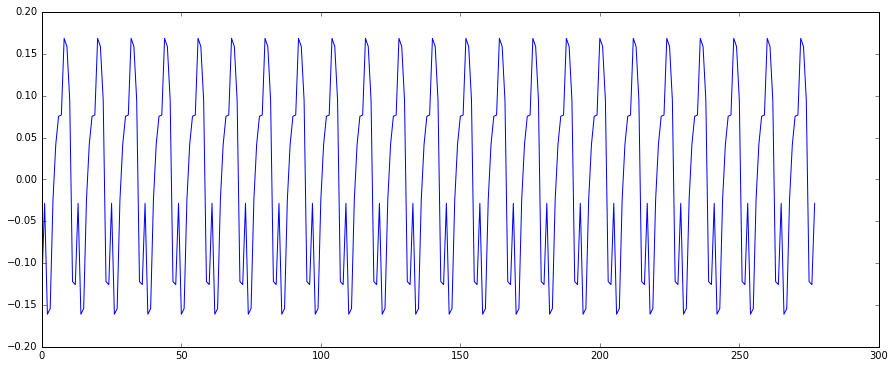

In [67]:
seasonal2=np.append(ss,seasonal["2015-07-31":"2016-06-30"])
plt.plot(seasonal2)
seasonal2

In [63]:
trend.dropna(inplace=True)
trend

Date
1994-05-31     3.298154
1994-06-30     3.346454
1994-07-31     3.488087
1994-08-31     3.700121
1994-09-30     3.951392
1994-10-31     4.216117
1994-11-30     4.446800
1994-12-31     4.676938
1995-01-31     4.909637
1995-02-28     5.140562
1995-03-31     5.379638
1995-04-30     5.639575
1995-05-31     5.955204
1995-06-30     6.287008
1995-07-31     6.518354
1995-08-31     6.671708
1995-09-30     6.781358
1995-10-31     6.866029
1995-11-30     6.978679
1995-12-31     7.095117
1996-01-31     7.212937
1996-02-29     7.329833
1996-03-31     7.435542
1996-04-30     7.527904
1996-05-31     7.578221
1996-06-30     7.595229
1996-07-31     7.617654
1996-08-31     7.644000
1996-09-30     7.672000
1996-10-31     7.706354
                ...    
2014-01-31    13.050479
2014-02-28    13.069708
2014-03-31    13.086929
2014-04-30    13.114829
2014-05-31    13.158288
2014-06-30    13.244358
2014-07-31    13.368767
2014-08-31    13.497908
2014-09-30    13.650775
2014-10-31    13.824608
2014-11-30 

In [72]:
unos = np.ones(12)
trend2 = np.append(trend,unos*trend[-1])

In [73]:
trend2

array([  3.29815417,   3.34645417,   3.4880875 ,   3.70012083,
         3.95139167,   4.21611667,   4.4468    ,   4.6769375 ,
         4.9096375 ,   5.1405625 ,   5.3796375 ,   5.639575  ,
         5.95520417,   6.28700833,   6.51835417,   6.67170833,
         6.78135833,   6.86602917,   6.97867917,   7.09511667,
         7.2129375 ,   7.32983333,   7.43554167,   7.52790417,
         7.57822083,   7.59522917,   7.61765417,   7.644     ,
         7.672     ,   7.70635417,   7.74399583,   7.77949167,
         7.80595   ,   7.8275125 ,   7.848525  ,   7.86407083,
         7.8847375 ,   7.91015   ,   7.93717083,   7.982925  ,
         8.03757917,   8.0879    ,   8.14110417,   8.20990833,
         8.29329583,   8.40248333,   8.57030417,   8.76725833,
         8.93332083,   9.078175  ,   9.23152083,   9.37336667,
         9.48452917,   9.5717375 ,   9.6442125 ,   9.70276667,
         9.7471625 ,   9.76789583,   9.73242917,   9.67150833,
         9.62415   ,   9.58115   ,   9.53473333,   9.48

In [74]:
len(trend2),len(seasonal2)

(278, 278)

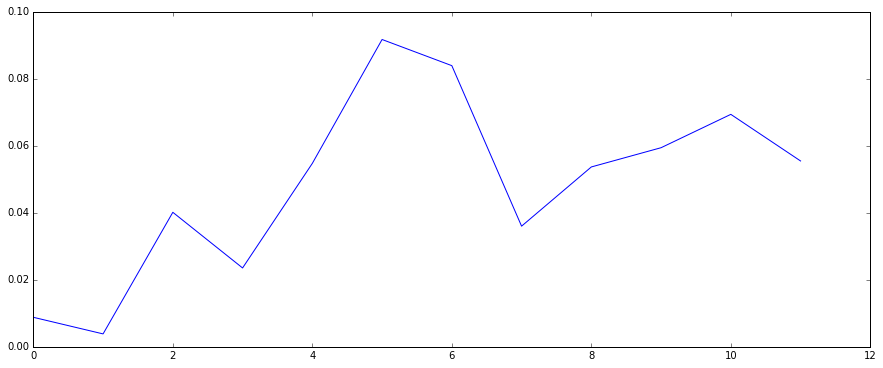

In [90]:
ca = np.random.randn(12)
plt.plot(ca.cumsum()/18)

In [91]:
residual.dropna(inplace=True)

In [92]:
residual2 = np.append(residual,ca)
len(residual2)

278

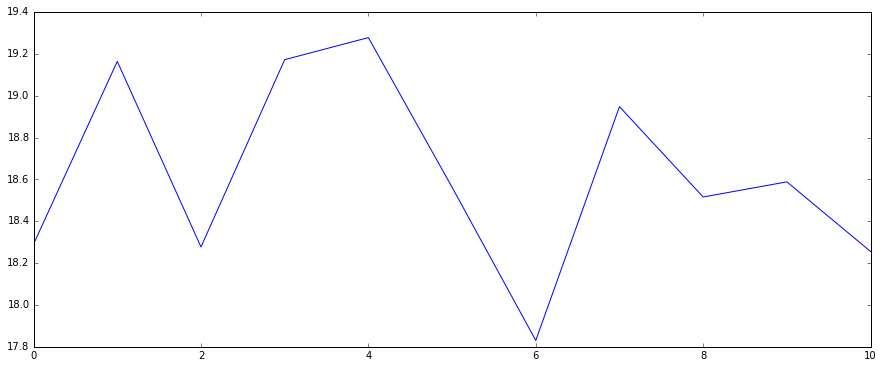

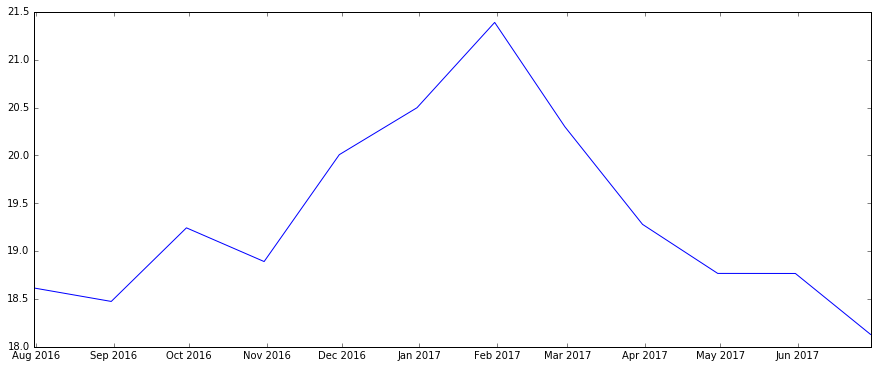

In [93]:
prediccion=trend2+seasonal2+residual2
plt.plot(prediccion[-11:])
plt.show()
plt.plot(ts["2016-07-31":"2017-06-30"])
plt.show()

In [94]:
test_stationarity(prediccion)

AttributeError: 'numpy.ndarray' object has no attribute 'rolling'

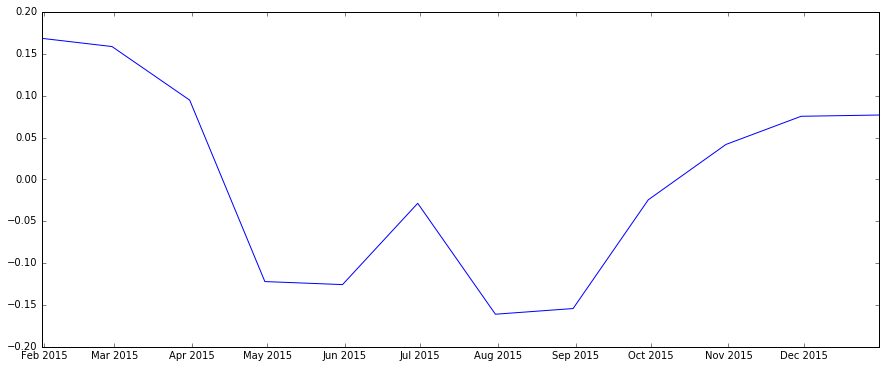

In [98]:
plt.plot(seasonal["2015"])